# Benchmark of loading dataset approaches in TensorFlow

This notebook benchmarks four different approaches to input a dataset to fit a model using TensorFlow. While it is possible to do it with a custom generator, the `tf.data` API offers possibilities which may be more confortable and even more efficient. Here the tested approaches:

* **a)** Using `.from_tensor_slices()`
* **b)** Using `.from_generator()`
* **c)** Using `.flow_from_directory()`
* **d)** Using `.tfrecords`

Let's start by importing the required packages and the configuration stored in `parameters.ini`.

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "DatasetLoadingBenchmark.ipynb")
import utils
import configparser

config = configparser.ConfigParser()
config.read('parameters.ini')
N = int(config['DEFAULT']['n'])
HEIGHT = int(config['DEFAULT']['height'])
WIDTH = int(config['DEFAULT']['width'])
BATCH_SIZE = int(config['DEFAULT']['batch_size'])
BUFFER_SIZE = int(config['DEFAULT']['buffer_size'])
EPOCHS = int(config['DEFAULT']['epochs'])
STEPS = N // BATCH_SIZE

### Download toy data

To benchmark the dataset creation approaches, we need a task to solve, a toy dataset and a model to train. We will solve a segmentation task on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)) with the UNet-like model provided in the [Image Segmentation TensorFlow tutorial](https://www.tensorflow.org/tutorials/images/segmentation). The next line of code downloads the dataset and structures it as follows in the determined `project` directory indicated with the variable `DATA_PATH`, defined in `parameters.ini`. It may take a couple of minutes.
```
{DATA_PATH}
|
└───images
│   |   image001.png
│   |   image002.png
│   |   ...
|
└───masks
    │   mask001.png
    │   mask002.png
    |   ...
```

In [3]:
DATA_PATH = os.path.join(os.getcwd(), "Data")
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

utils.download_data(DATA_PATH)

Data is already in indicated path: ..\Data


### Create TensorFlow datasets with different approaches

##### **a)** Using `.from_tensor_slices()`

In [3]:
from DatasetLoadingApproaches import using_from_tensor_slices
dataset_a = using_from_tensor_slices.get_dataset(DATA_PATH, BATCH_SIZE, BUFFER_SIZE)

for batch in dataset_a.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

NameError: name 'DATA_PATH' is not defined

##### **b)** Using `.from_generator()`

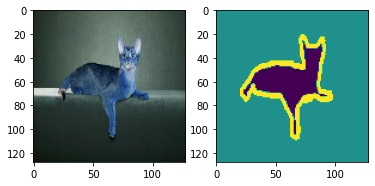

In [5]:
from DatasetLoadingApproaches import using_from_generator

generator_b = using_from_generator.get_generator(DATA_PATH, BATCH_SIZE)
dataset_b = using_from_generator.get_dataset(DATA_PATH, BATCH_SIZE)

for batch in dataset_b.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

##### **c)** Using `.flow_from_directory()`

For this approach, we need to structure out data in subdirectories.

In [6]:
utils.structure_data_in_subdirectories(DATA_PATH)

Data is already in paths: ..\directory_images, ..\directory_masks


Create dataset

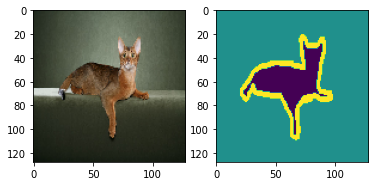

In [7]:
from DatasetLoadingApproaches import using_flow_from_directory

directory_images_path = os.path.join(DATA_PATH, "directory_images")
directory_masks_path = os.path.join(DATA_PATH, "directory_masks")
generator_c = using_flow_from_directory.get_generator(directory_images_path, directory_masks_path, BATCH_SIZE)
dataset_c = using_flow_from_directory.get_dataset(directory_images_path, directory_masks_path, BATCH_SIZE)

for batch in dataset_c.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

##### **d)** Using `.tfrecords`

Create TFRECORDS files

In [8]:
from DatasetLoadingApproaches import tfrecords_creation

MAX_FILES = 15

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
if utils.get_size_in_megabytes(tfrecords_path) > 1800:
    print(f"TFRECORDS files are already in path: ..\{os.path.basename(tfrecords_path)}")
else:
    if not os.path.isdir(tfrecords_path):
        os.mkdir(tfrecords_path)
    tfrecords_creation.dynamic_write_images_to_tfr(DATA_PATH, MAX_FILES, tfrecords_path, filename="animals")

TFRECORDS files are already in path: ..\TFRecords


Create dataset

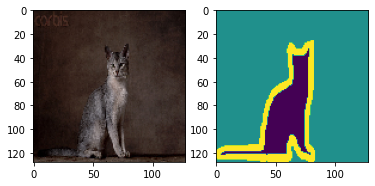

In [9]:
from DatasetLoadingApproaches import using_tfrecords

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
dataset_d = using_tfrecords.get_dataset(tfrecords_path, "animals*.tfrecords", BATCH_SIZE, BUFFER_SIZE)

for batch in dataset_c.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

### Benchmark training performance

Define model

In [10]:
subprocess.check_call(["pip", "install", "git+https://github.com/tensorflow/examples.git"])

from segmentation_model import unet_model
model = unet_model(output_channels=3)

Segmentation Models: using `tf.keras` framework.


Train model with different dataset creation approaches

In [12]:
WANDB_ENTITY_NAME = "boadagu"
WANDB_PROJECT_NAME = "DatasetLoadingBenchmark"

datasets = [dataset_a, generator_b, dataset_b, dataset_c, dataset_d]
run_names = ["Using .from_tensor_slices()", "Using simple generator", "Using .from_generator()", "Using .flow_from_directory()", "Using .tfrecords"]
for run_name,dataset in zip(run_names, datasets):
    wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY_NAME, name=run_name + f" [{EPOCHS} epochs]")
    model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS, callbacks=[utils.MonitorCallback()])
    wandb.finish()

RAM (%),▁
RAM (MB),▁
VRAM (MB) from smi,▁
VRAM (MB) from tf,▁
RAM (%),64.3
RAM (MB),20905.52344
VRAM (MB) from smi,6046.08922
VRAM (MB) from tf,67.39771


Epoch 1/100
657/923 [====================>.........] - ETA: 10s - loss: 0.2739 - accuracy: 0.8954

KeyboardInterrupt: 

### Results
<img src="TrainingTimes.png" style="width: 1000px;"/>
<!-- Times in seconds are: [310, 361, 407, 383, 362] -->

Using `.tfrecords` is the fasted (5 min 10 s) approach compared to the other ones (Average: 6 min 20 s). This is because TFRECORDS files save the data in a binarized format and in a sequentially structure, so that samples can be accessed faster. 